## Transferaufgabe -- Sentiment Analyse
1 [Datensatz](#dataset)

1.1 [Analyse](#analyse)

1.2 [Preprocess](#preprocess)

2 [Sentiment Analyse](#sentiment)

2.1 [GloVe Embeddings](#glove)

2.1.1 [NN](#nn)

2.1.2 [CNN](#cnn)

2.1.3 [LSTM](#lstm)

2.2 [BERT](#BERT)

2.2.1 [BERT-Tokenizer](#BERT_T)

2.2.2 [BERT-Model](#BERT_M)

2.2.3 [ktrain](#ktrain)

3 [Ergebnis](#ergebnis)







## 1 Datensatz <a class="anchor" id="dataset"></a>
### 1.1 Analyse <a class="anchor" id="analyse"></a>

In [11]:
from google.colab import drive


In [12]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [13]:
#Datensatz laden
import pandas as pd

df = pd.read_csv("/content/gdrive/My Drive/IMDB_dataset.csv")

In [ ]:
df.head()
#del df["Unnamed: 0"]

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

counts = Counter(df["sentiment"])

In [ ]:
counts

Counter({'negative': 25000, 'positive': 25000})

Die Verteilung der Labels zeigt einen ausgewogenen Datensatz.

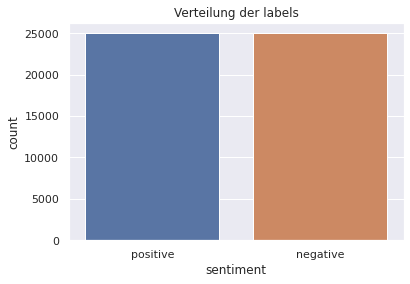

In [ ]:
import seaborn as sns
sns.set(style="darkgrid")
ax = sns.countplot(x="sentiment", data=df)
plt.title("Verteilung der labels")
plt.savefig("/content/gdrive/My Drive/sentiment_barplot.png", bbox_inches='tight')

In [ ]:
df = df[df['review'].notnull()]

In [ ]:
len(df)

50000

In [9]:
from collections import Counter
for i,row in df.iterrows():
    c = Counter(row.review.split())
    df.at[i, 'number_of_tokens'] = sum(c.values())
    df.at[i, 'number_of_types'] = int(len(c))

Die Verteilung der Songlängen pro Label zeigt ebenfalls ein einheitliche Länge.

Text(0.5, 1.0, 'Songlength per Label')

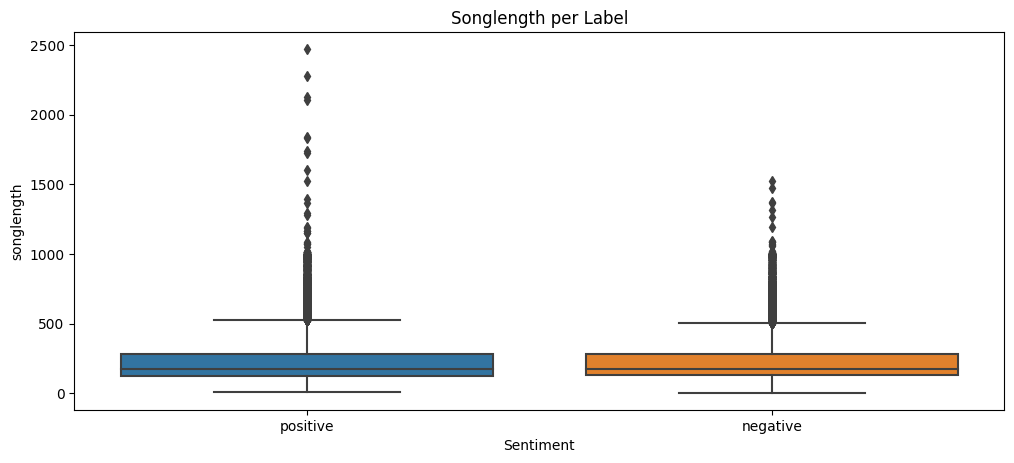

In [10]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(12,5))
sns.boxplot(x=df.sentiment, y=df.number_of_tokens)
ax.set_ylabel("songlength")
ax.set_xlabel("Sentiment")
plt.title("Songlength per Label")
#plt.savefig("../../images/longtexts/songlength_per_genre")

Die Anzahl der Tokens beträgt zwischen 0 und 500. 

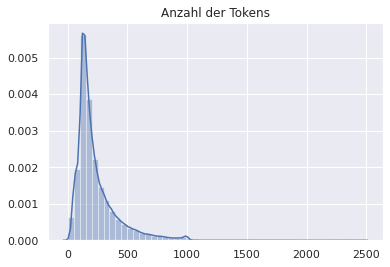

In [ ]:
ax = sns.distplot(list(df.number_of_tokens))
plt.title("Anzahl der Tokens")
plt.savefig("/content/gdrive/My Drive/number_of_tokens.png", bbox_inches='tight')

WordClouds für negativ gelabelte und positiv gelabelte Rezensionen geben einen ersten Eindrück über den Inhalt der Texte. 

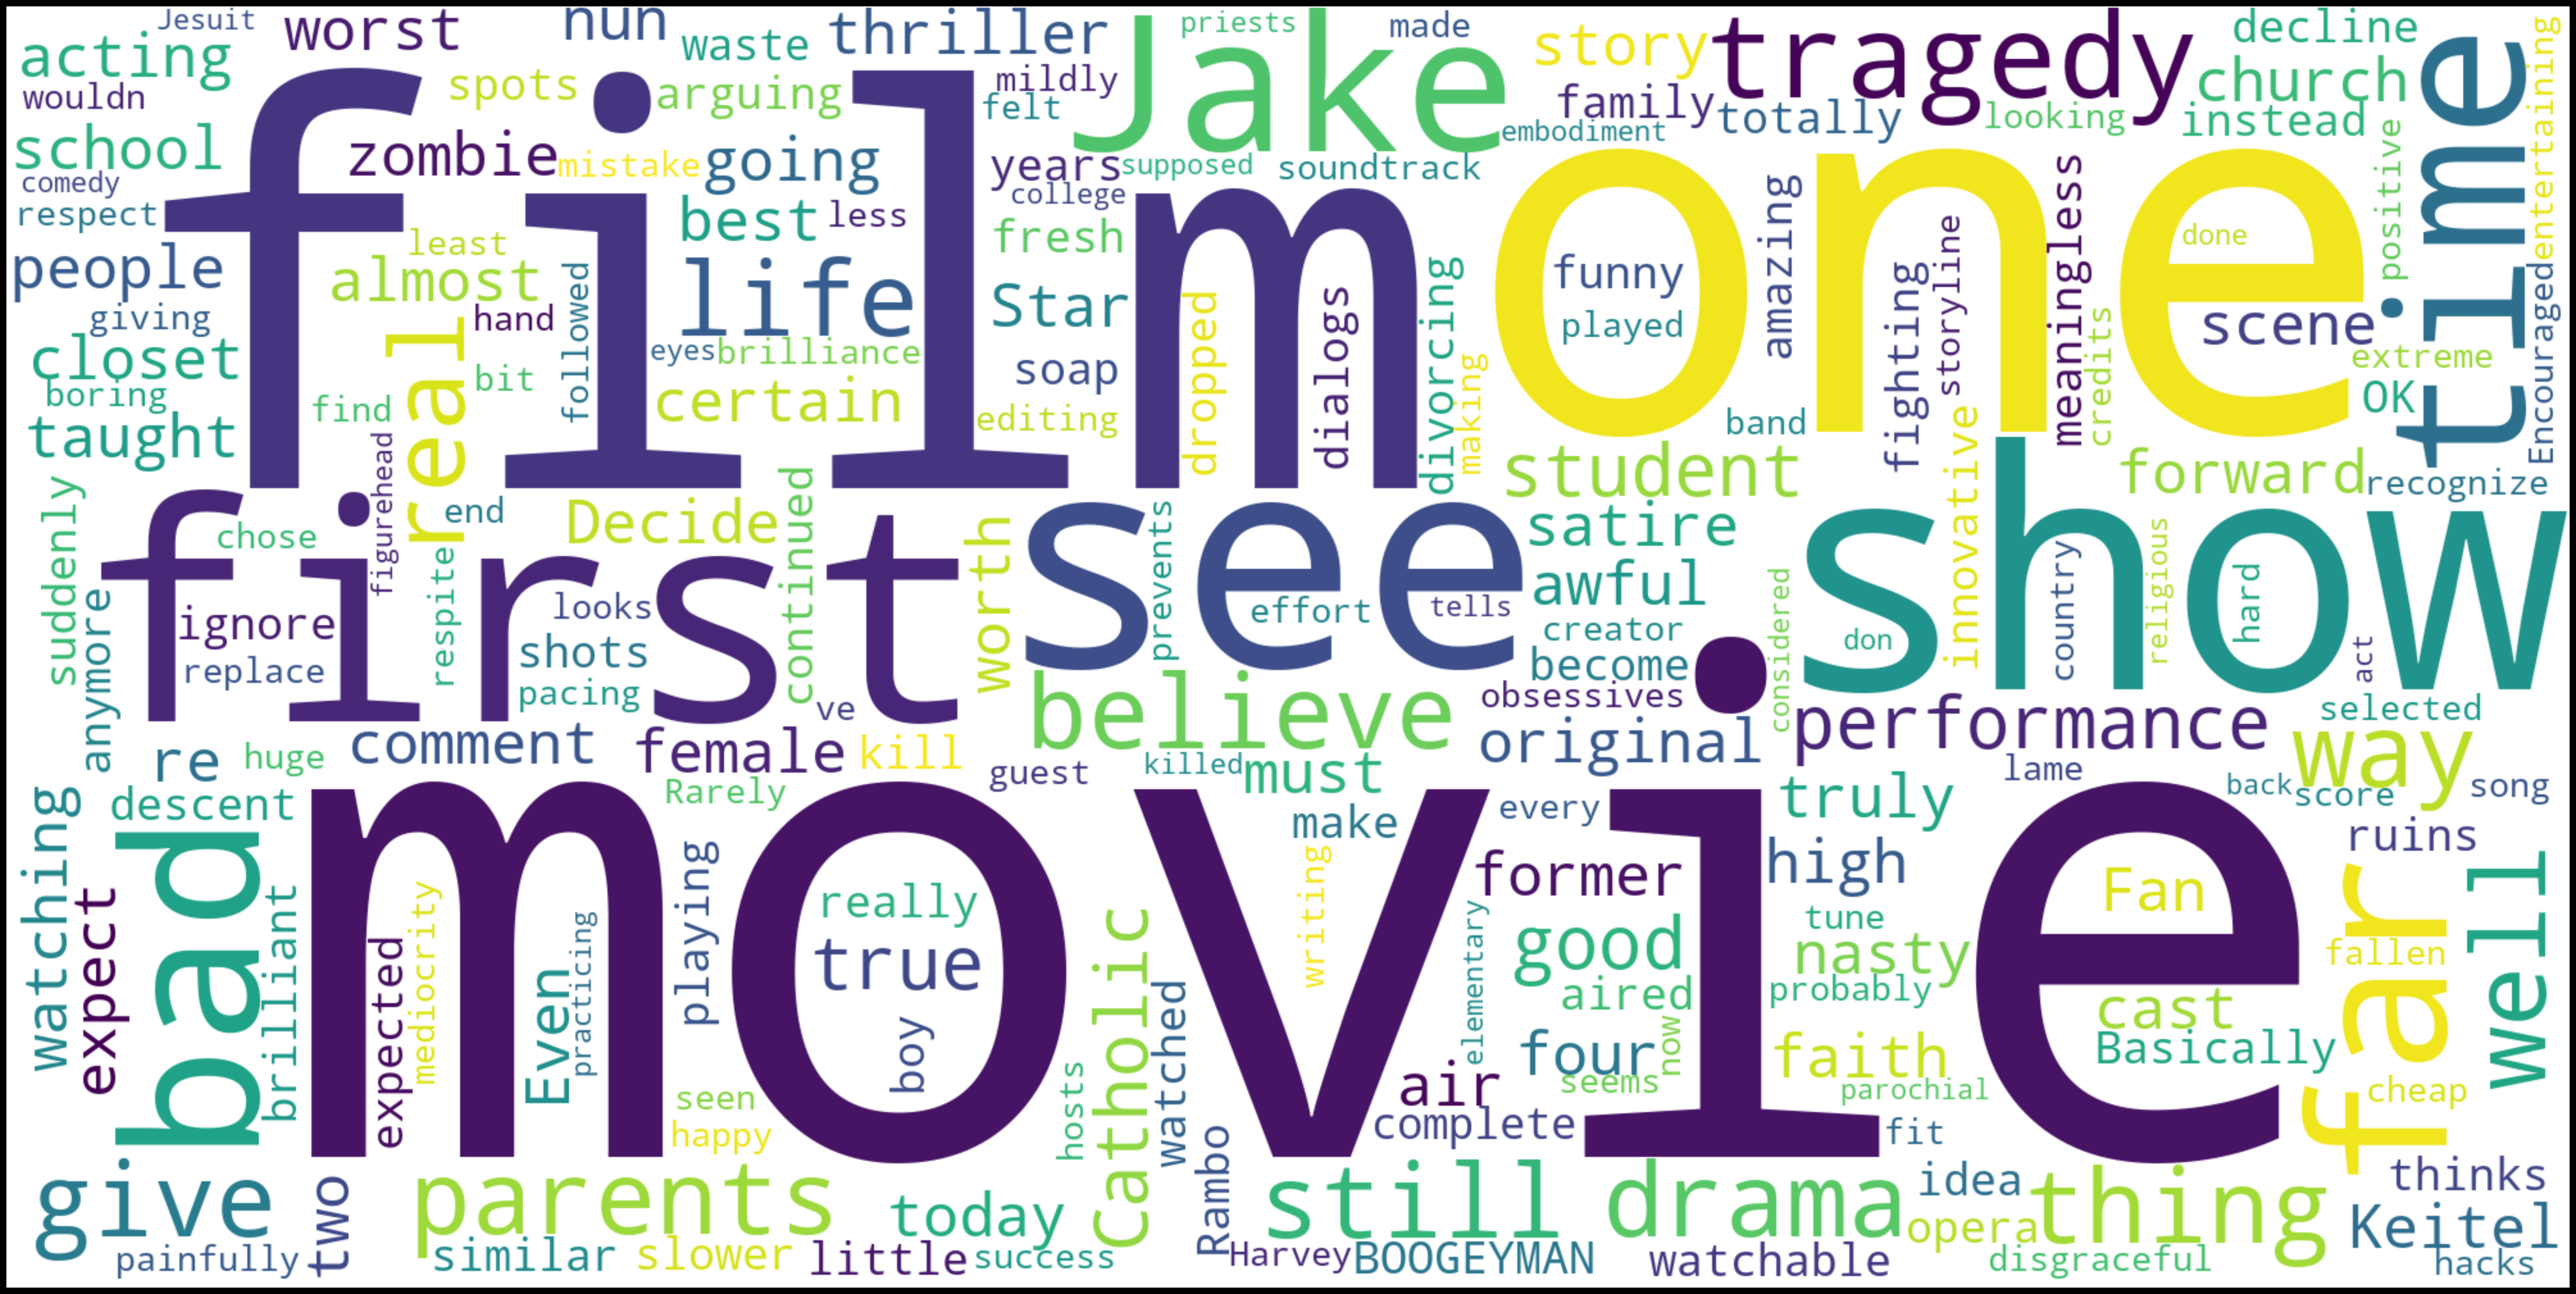

In [18]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
pos_df = df.loc[df['sentiment'] == "positive"] 
neg_df = df.loc[df['sentiment'] == "negative"] 
text = neg_df.review_clean.values
wordcloud = WordCloud(
    width = 2000,
    height = 1000,
    background_color = 'white',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.savefig("/content/gdrive/My Drive/neg_wordclouds.png", bbox_inches='tight')

### 1.2 Preprocess <a class="anchor" id="preprocess"></a>

In [ ]:
df["review"][45]

"As a disclaimer, I've seen the movie 5-6 times in the last 15 years, and I only just saw the musical this week. This allowed me to judge the movie without being tainted by what was or wasn't in the musical (however, it tainted me when I watched the musical :) ) <br /><br />I actually believe Michael Douglas worked quite well in that role, along with Kasey. I think her 'Let me dance for you scene' is one of the best parts of the movie, a worthwhile addition compared to the musical. The dancers and singing in the movie are much superior to the musical, as well as the cast which is at least 10 times bigger (easier to do in the movie of course). The decors, lighting, dancing, and singing are also much superior in the movie, which should be expected, and was indeed delivered. <br /><br />The songs that were in common with the musical are better done in the movie, the new ones are quite good ones, and the whole movie just delivers more than the musical in my opinion, especially compared to 

In [14]:
import re 

html_tags = re.compile(r'<[^>]+>')

def remove_tags(text):
    return html_tags.sub('', text)

def preprocess_text(sen):
    # html tags entfernen
    sentence = remove_tags(sen)

    # Zahlen und Interpunktionen entfernen
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # single character entfernen
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # mehrere Leerzeichen entfernen 
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [15]:
# die Texte werden bearbeitet und in eine neue Kolumne gespeichert
df["review_clean"] = df.review.apply(preprocess_text)

In [ ]:
# bearbeiteten Texte werden in eine Liste gespeichert
import re
X=[]
#X = list(df["review_clean"])
sentences = list(df['review'])
for sen in sentences:
  X.append(preprocess_text(sen))

Als nächstes müssen die labels als Zahlen dargestellt werden. Da es sich bei dem Datensatz nur um "positiv" oder "negativ" handelt, werden die Zahlen 1 und 0 herangezogen.

In [ ]:

import numpy as np
y = df['sentiment']
# positiv = 1, negativ = 0
y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [ ]:
# Der Output nach dem Preprocessing zeigt, dass nur noch die Buchstaben übrig geblieben sind.
X[45]

'As disclaimer ve seen the movie times in the last years and only just saw the musical this week This allowed me to judge the movie without being tainted by what was or wasn in the musical however it tainted me when watched the musical actually believe Michael Douglas worked quite well in that role along with Kasey think her Let me dance for you scene is one of the best parts of the movie worthwhile addition compared to the musical The dancers and singing in the movie are much superior to the musical as well as the cast which is at least times bigger easier to do in the movie of course The decors lighting dancing and singing are also much superior in the movie which should be expected and was indeed delivered The songs that were in common with the musical are better done in the movie the new ones are quite good ones and the whole movie just delivers more than the musical in my opinion especially compared to musical which has few decors The one bad point on the movie is the obvious cuts

## 2 Sentiment Analyse <a class="anchor" id="sentiment"></a>
### 2.1 GloVe Embeddings <a class="anchor" id="glove"></a>
Quelle: https://stackabuse.com/python-for-nlp-movie-sentiment-analysis-using-deep-learning-in-keras/, aufgerufen am 04.09.2020.

Nun wird unser Datensatz in Test- und Trainingsdaten geteilt. Dabei macht der Trainingsdatensatz 80% und der Testdatensatz 20% unseres Datensatzes aus.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

Durch den embedding layer werden unsere textuellen Daten in numerische umgewandelt, wobei jedes Wort im Korpus eine ID zugeschrieben bekommt. Mithilfe des keras.preprocessing.text Modul wird so ein Word-to-Index Dictionary erstellt.

In [ ]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
X_train[45]

[4936,
 1016,
 281,
 8,
 16,
 13,
 1,
 83,
 53,
 118,
 2,
 6,
 5,
 77,
 54,
 83,
 547,
 3,
 1718,
 23,
 4,
 967,
 10,
 48,
 1489,
 29,
 8,
 16,
 11,
 320,
 3,
 314,
 2,
 445,
 101,
 1269,
 4,
 1,
 2225,
 2779,
 2,
 2772,
 31,
 5,
 668,
 3408,
 4036,
 8,
 16,
 7,
 9,
 6,
 2090,
 45,
 156,
 3341,
 680,
 1166,
 1353,
 9,
 35,
 20,
 44,
 18,
 127,
 31,
 23,
 235,
 188,
 7,
 54,
 650,
 6,
 1365,
 1,
 2220,
 3,
 53,
 11,
 476,
 463,
 3,
 7729,
 739,
 110,
 2,
 41,
 229,
 1519,
 4,
 1,
 432,
 29,
 1769,
 98,
 9,
 20,
 47,
 68,
 1,
 2773,
 1961,
 57,
 308,
 4,
 32,
 7799,
 101,
 144,
 41,
 17,
 46,
 72,
 1038,
 3,
 8,
 16,
 56,
 367,
 17,
 72,
 1038,
 3,
 6,
 841,
 131,
 101,
 1269,
 688,
 582,
 18,
 2694,
 1556,
 228,
 77,
 1251,
 4,
 23,
 63,
 1,
 1409,
 4,
 99,
 157,
 410,
 3,
 160,
 29,
 2950,
 2009,
 7,
 1218,
 1188,
 1324,
 17]

Da sowohl X_train als auch X_test aus unterschiedlich langen Listen aufgrund der Satzlängen bestehen, müssen diese auf eine Standardlänger gesetzt werden. Diesen Schritt nennt man Padding, bei dem lange Sätze ab einer festgelegten Länge abgeschnitten und kürzere Sätze mit Paddingzeichen, in diesem Fall 0 aufgefüllt werden.

In [ ]:
from keras.preprocessing.sequence import pad_sequences
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1
# Länge der Listen
maxlen = 100

print("Größe des Vokabulars: ", vocab_size)

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

Größe des Vokabulars:  92547


Für den embedding layer werden zunächst GloVe embeddings verwendet, um eine feature-matrix zu erstellen. Nachdem die Embeddings geladen wurden, wird ein Dictionary erstellt, dass als Keys Wörter und als Values die entsprechenden Embeddings besitzt.

In [ ]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('/content/gdrive/My Drive/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

In [ ]:
embedding_size = 100
# leere Matrix mit Zeilen für jedes Wort und Spalten in der Größe des embedding Vektors
embedding_matrix = zeros((vocab_size, embedding_size))

for word, index in tokenizer.word_index.items():
    #try: 
    embedding_vector = embeddings_dictionary.get(word)
    #except KeyError:
        #embedding_vector = None
        #print("not in embeddings: ", word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

print("\nshape of matrix: ", embedding_matrix.shape)


shape of matrix:  (92547, 100)


Die Embedding-Matrix enthält 92547 Zeilen, davon eine für jedes Wort im Korpus.

#### 2.1.1 NN <a class="anchor" id="nn"></a>

In [ ]:
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding

In [ ]:
model = Sequential()
# trainable = False, da wir pre-trained Embeddings verwenden 
embedding_layer = Embedding(vocab_size, embedding_size, weights=[embedding_matrix], input_length=maxlen , trainable=False)
# als erster Layer wird der Embedding-Layer übergeben 
model.add(embedding_layer)

model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          9254700   
_________________________________________________________________
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                320032    
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 9,575,821
Trainable params: 321,121
Non-trainable params: 9,254,700
_________________________________________________________________
None


Evaluate the model

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
len(X_test)

10000

In [ ]:
history = model.fit(X_train, y_train,
                    epochs=5,
                    batch_size=32, 
                    verbose= 1,
                    validation_split= 0.2)
#model.save_weights('pre_trained_glove_model_simple_nn.h5')
#model.save("pre_trained_glove_model_simple_nn.h5")

Epoch 1/5
1000/1000 [==============================] - 5s 5ms/step - loss: 0.5912 - acc: 0.6841 - val_loss: 0.5310 - val_acc: 0.7341
Epoch 2/5
1000/1000 [==============================] - 5s 5ms/step - loss: 0.4943 - acc: 0.7604 - val_loss: 0.5285 - val_acc: 0.7310
Epoch 3/5
1000/1000 [==============================] - 5s 5ms/step - loss: 0.4484 - acc: 0.7881 - val_loss: 0.5269 - val_acc: 0.7405
Epoch 4/5
1000/1000 [==============================] - 5s 5ms/step - loss: 0.4178 - acc: 0.8090 - val_loss: 0.5287 - val_acc: 0.7330
Epoch 5/5
1000/1000 [==============================] - 5s 5ms/step - loss: 0.3760 - acc: 0.8286 - val_loss: 0.5751 - val_acc: 0.7444


In [ ]:
score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

313/313 [==============================] - 1s 2ms/step - loss: 0.5782 - acc: 0.7391
Test Score: 0.5781545042991638
Test Accuracy: 0.7390999794006348


#### 2.1.2 CNN <a class="anchor" id="cnn"></a>

In [ ]:
from keras.layers.convolutional import Conv1D 
model = Sequential()

embedding_layer = Embedding(vocab_size, embedding_size, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model.summary())
#model.save("pre_trained_glove_model_cnn.h5")

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          9254700   
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 128)           64128     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 9,318,957
Trainable params: 64,257
Non-trainable params: 9,254,700
_________________________________________________________________
None


In [ ]:
history = model.fit(X_train, y_train, batch_size=32, epochs=6, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)

Epoch 1/6
1000/1000 [==============================] - 25s 25ms/step - loss: 0.4421 - acc: 0.7908 - val_loss: 0.3654 - val_acc: 0.8357
Epoch 2/6
1000/1000 [==============================] - 25s 25ms/step - loss: 0.3342 - acc: 0.8542 - val_loss: 0.3485 - val_acc: 0.8428
Epoch 3/6
1000/1000 [==============================] - 25s 25ms/step - loss: 0.2736 - acc: 0.8872 - val_loss: 0.3464 - val_acc: 0.8461
Epoch 4/6
1000/1000 [==============================] - 25s 25ms/step - loss: 0.2213 - acc: 0.9143 - val_loss: 0.3676 - val_acc: 0.8432
Epoch 5/6
1000/1000 [==============================] - 25s 25ms/step - loss: 0.1711 - acc: 0.9376 - val_loss: 0.4009 - val_acc: 0.8341
Epoch 6/6
313/313 [==============================] - 3s 10ms/step - loss: 0.3729 - acc: 0.8486


In [ ]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.37286341190338135
Test Accuracy: 0.8485999703407288


#### 2.1.3 RNN <a class="anchor" id="lstm"></a>

In [ ]:
from keras.layers.recurrent import LSTM

model = Sequential()
embedding_layer = Embedding(vocab_size, embedding_size, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(LSTM(128))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          9254700   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense_4 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 9,376,109
Trainable params: 121,409
Non-trainable params: 9,254,700
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train, batch_size=32, epochs=5, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)

Epoch 1/5
1000/1000 [==============================] - 94s 94ms/step - loss: 0.4836 - acc: 0.7710 - val_loss: 0.4349 - val_acc: 0.7979
Epoch 2/5
1000/1000 [==============================] - 93s 93ms/step - loss: 0.3952 - acc: 0.8205 - val_loss: 0.3796 - val_acc: 0.8304
Epoch 3/5
1000/1000 [==============================] - 93s 93ms/step - loss: 0.3568 - acc: 0.8421 - val_loss: 0.3516 - val_acc: 0.8464
Epoch 4/5
1000/1000 [==============================] - 93s 93ms/step - loss: 0.3257 - acc: 0.8587 - val_loss: 0.3502 - val_acc: 0.8441
Epoch 5/5
313/313 [==============================] - 10s 31ms/step - loss: 0.3309 - acc: 0.8614


In [ ]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.33090972900390625
Test Accuracy: 0.8614000082015991


Predict Model

In [ ]:
data = 'The plot had too many holes.'
data1 = 'This is the shit!'

In [ ]:
instance = tokenizer.texts_to_sequences(data1)

flat_list = []
for sublist in instance:
    for item in sublist:
        flat_list.append(item)

flat_list = [flat_list]

instance = pad_sequences(flat_list, padding='post', maxlen=maxlen)

model.predict(instance)

array([[0.96233374]], dtype=float32)

### 2.2 BERT <a class="anchor" id="BERT"></a>
#### 2.2.1 BERT-Tokenizer <a class="anchor" id="BERT_T"></a>
Quelle: https://stackabuse.com/text-classification-with-bert-tokenizer-and-tf-2-0-in-python/, aufgerufen am 04.09.2020.

In [ ]:
# BERT für Tensorflow 2.0 installieren
!pip install bert-for-tf2
!pip install sentencepiece

In [ ]:
# TensorFlow 2.0
try:
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

import tensorflow_hub as hub

from tensorflow.keras import layers
import bert

In [ ]:
# vorverarbeiteten Datensatz verwenden
reviews = list(df["review_clean"])

In [ ]:
# Labels als Zahlen
import numpy as np
y = df['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [ ]:
print(reviews[10])

Phil the Alien is one of those quirky films where the humour is based around the oddness of everything rather than actual punchlines At first it was very odd and pretty funny but as the movie progressed didn find the jokes or oddness funny anymore Its low budget film thats never problem in itself there were some pretty interesting characters but eventually just lost interest imagine this film would appeal to stoner who is currently partaking For something similar but better try Brother from another planet 


In [ ]:
print(y[10])

0


Create BERT-Tokenizer

Bevor man die BERT-Embeddings als Input in das Model einspeisen kann, muss man zuerst die Rezensionen tokenisieren. Dazu wird der BERT Tokenizer verwendet. 
Im folgenden Script wird ein Objekt vom bert.bert_tokenization Modul erstellt. Danach wird ein BERT embedding layer definiert. 
Die Variablen vocabulary_file und to_lower_case werden dem Tokenizer-Objekt übergeben. 

In [ ]:
BertTokenizer = bert.bert_tokenization.FullTokenizer
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
                            trainable=False)
vocabulary_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
to_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = BertTokenizer(vocabulary_file, to_lower_case)

In [ ]:
# show BERT tokenizer
tokenizer.tokenize("don't be so judgmental")

['don', "'", 't', 'be', 'so', 'judgment', '##al']

In [ ]:
tokenizer.convert_tokens_to_ids(tokenizer.tokenize("dont be so judgmental"))

[2123, 2102, 2022, 2061, 8689, 2389]

Die Funktion tokenize_reviews bekommt als Input eine Rezension und gibt die IDs der tokenisierten Wörter aus.

In [ ]:
def tokenize_reviews(text_reviews):
    return tokenizer.convert_tokens_to_ids(tokenizer.tokenize(text_reviews))

In [ ]:
# Rezensionen tokenisieren
tokenized_reviews = [tokenize_reviews(review) for review in reviews]

Da die Rezension aus unterschiedlichen Längen bestehen, werden sie innerhalb jedes batch anhand des längsten Textes aufgefüllt.
Zunächst gibt man die Länge der Rezensionen als Liste aus, die wiederum nach der Länge sortiert wird. Nachdem die Länge wieder entfernt wurde, wird der Datensatz für TensorFlow 2.0 in Form gebracht. 
Zum Schluss kann der Datensatz für jedes Batch aufgefüllt werden. Batch-Size ist hier 32, das heißt, dass nach 32 Rezensionen, die Gewichte des Netzwerks geupdatet werden. 


In [ ]:
reviews_with_len = [[review, y[i], len(review)]
                 for i, review in enumerate(tokenized_reviews)]

In [ ]:
import random
random.shuffle(reviews_with_len)

In [ ]:
# nach Länge sortieren
reviews_with_len.sort(key=lambda x: x[2])

In [ ]:
# Länge entfernen
sorted_reviews_labels = [(review_lab[0], review_lab[1]) for review_lab in reviews_with_len]

In [ ]:
processed_dataset = tf.data.Dataset.from_generator(lambda: sorted_reviews_labels, output_types=(tf.int32, tf.int32))

In [ ]:
# Datensatz für jedes Batch padden 
BATCH_SIZE = 32
batched_dataset = processed_dataset.padded_batch(BATCH_SIZE, padded_shapes=((None, ), ()))

In [ ]:
# Datensatz in Trainings- und Testdaten teilen
# 10% Testdaten
import math
TOTAL_BATCHES = math.ceil(len(sorted_reviews_labels) / BATCH_SIZE)
TEST_BATCHES = TOTAL_BATCHES // 10
batched_dataset.shuffle(TOTAL_BATCHES)
test_data = batched_dataset.take(TEST_BATCHES)
train_data = batched_dataset.skip(TEST_BATCHES)

Create Model

Eine Model Klasse vom tf.keras.Model wird erstellt. Darin befinden sich 3 CNN layer mit kernel 2, 3 und 4. 
In der call() FUnktion wird zu jedem Output der Layer global max pooling hinzugefügt.
Schließlich werden alle Layer verbunden. 

In [ ]:
class BERT_Tok(tf.keras.Model):
    
    def __init__(self,
                 vocabulary_size,
                 embedding_dimensions=128,
                 cnn_filters=50,
                 dnn_units=512,
                 model_output_classes=2,
                 dropout_rate=0.1,
                 training=False,
                 name="text_model"):
        super(TEXT_MODEL, self).__init__(name=name)
        
        self.embedding = layers.Embedding(vocabulary_size,
                                          embedding_dimensions)
        self.cnn_layer1 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=2,
                                        padding="valid",
                                        activation="relu")
        self.cnn_layer2 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=3,
                                        padding="valid",
                                        activation="relu")
        self.cnn_layer3 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=4,
                                        padding="valid",
                                        activation="relu")
        self.pool = layers.GlobalMaxPool1D()
        
        self.dense_1 = layers.Dense(units=dnn_units, activation="relu")
        self.dropout = layers.Dropout(rate=dropout_rate)
        if model_output_classes == 2:
            self.last_dense = layers.Dense(units=1,
                                           activation="sigmoid")
        else:
            self.last_dense = layers.Dense(units=model_output_classes,
                                           activation="softmax")
    
    def call(self, inputs, training):
        l = self.embedding(inputs)
        l_1 = self.cnn_layer1(l) 
        l_1 = self.pool(l_1) 
        l_2 = self.cnn_layer2(l) 
        l_2 = self.pool(l_2)
        l_3 = self.cnn_layer3(l)
        l_3 = self.pool(l_3) 
        
        concatenated = tf.concat([l_1, l_2, l_3], axis=-1) # (batch_size, 3 * cnn_filters)
        concatenated = self.dense_1(concatenated)
        concatenated = self.dropout(concatenated, training)
        model_output = self.last_dense(concatenated)
        
        return model_output

In [ ]:
# Variablen definieren
VOCAB_LENGTH = len(tokenizer.vocab)
EMB_DIM = 200
CNN_FILTERS = 100
DNN_UNITS = 256
OUTPUT_CLASSES = 2

DROPOUT_RATE = 0.2

NB_EPOCHS = 5

In [ ]:
# dem Model Variablen übergeben
text_model = BERT_Tok(vocabulary_size=VOCAB_LENGTH,
                        embedding_dimensions=EMB_DIM,
                        cnn_filters=CNN_FILTERS,
                        dnn_units=DNN_UNITS,
                        model_output_classes=OUTPUT_CLASSES,
                        dropout_rate=DROPOUT_RATE)

In [ ]:
if OUTPUT_CLASSES == 2:
    text_model.compile(loss="binary_crossentropy",
                       optimizer="adam",
                       metrics=["accuracy"])
else:
    text_model.compile(loss="sparse_categorical_crossentropy",
                       optimizer="adam",
                       metrics=["sparse_categorical_accuracy"])

In [ ]:
# model trainieren
text_model.fit(train_data, epochs=NB_EPOCHS)

Epoch 1/5
1407/1407 [==============================] - 139s 99ms/step - loss: 0.3054 - accuracy: 0.8650
Epoch 2/5
1407/1407 [==============================] - 101s 72ms/step - loss: 0.1365 - accuracy: 0.9489
Epoch 3/5
1407/1407 [==============================] - 101s 72ms/step - loss: 0.0728 - accuracy: 0.9735
Epoch 4/5
1407/1407 [==============================] - 101s 71ms/step - loss: 0.0343 - accuracy: 0.9878
Epoch 5/5
1407/1407 [==============================] - 101s 72ms/step - loss: 0.0198 - accuracy: 0.9930


In [ ]:
results = text_model.evaluate(test_data)
print(results)

156/156 [==============================] - 4s 27ms/step - loss: 0.4378 - accuracy: 0.9018
[0.43778136372566223, 0.9018429517745972]


#### 2.2.2 BERT-Model <a class="anchor" id="BERT_M"></a>
Quelle: https://github.com/abhimishra91/transformers-tutorials/blob/master/transformers_sentiment_wandb.ipynb, aufgerufen am 04.09.2020.

Zuerst wird die NLP-Transformers Library installiert, danach alle Module, die benötigt werden. 

In [ ]:
!pip install -q transformers

     |████████████████████████████████| 890kB 3.7MB/s 
     |████████████████████████████████| 1.1MB 13.0MB/s 
     |████████████████████████████████| 890kB 27.7MB/s 
     |████████████████████████████████| 3.0MB 35.0MB/s 


In [ ]:
# benötigte librarys importieren
import numpy as np
import pandas as pd
from sklearn import metrics
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig
from transformers import RobertaConfig, RobertaModel, RobertaTokenizer


In [ ]:
# GPU Nutzung 

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [ ]:
# Variablen definieren, die beim Training verwendet werden 
MAX_LEN = 200
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 2
EPOCHS = 2
LEARNING_RATE = 1e-05
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Die Preprocess Klasse verarbeitet den Text, bevor dieser tokenisiert werden kann. Der Da-tensatz wird geladen und aus der Spalte sentiment wird eine neue, namens encoded_polarity erstellt. In dieser sind die Polaritäten als Zahlen dargestellt. Danach wird die ursprüngliche Spalte gelöscht und das Dataframe und das Dictionary werden ausgegeben. 

In [ ]:
class Preprocess:
    def __init__(self, df):
        """
        Constructor for the class
        :param df: Input Dataframe to be pre-processed
        """
        self.df = df
        self.encoded_dict = dict()

    def encoding(self, x):
        if x not in self.encoded_dict.keys():
            self.encoded_dict[x] = len(self.encoded_dict)
        return self.encoded_dict[x]

    def processing(self):
        self.df['encoded_polarity'] = self.df['sentiment'].apply(lambda x: self.encoding(x))
        self.df.drop(['sentiment'], axis=1, inplace=True)
        return self.encoded_dict, self.df

Die Klasse CustomDataset akzeptiert das Dataframe als Input und generiert einen tokenisier-ten Output, welcher für das Training des BERT Models verwendet wird. In diesem Fall wird der BERT-Tokenizer herangezogen, um die Daten in review zu bearbeiten. Die Methode encoded_plus generiert neben der Tokenisierung, auch die ids und attention_maks, die für das Model benötigt werden. Die Polaritäten werden in einen targets tensor transformiert.

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __getitem__(self, index):
        text = str(self.data.review[index])
        text = " ".join(text.split())
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True, 
            truncation = True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'targets': torch.tensor(self.data.encoded_polarity[index], dtype=torch.float)
        } 
    
    def __len__(self):
        return self.len

In [ ]:
# Datensatz vorbereiten
#df = pd.read_csv("/content/gdrive/My Drive/IMDB_dataset.csv")
pre = Preprocess(df)
encoding_dict, df = pre.processing()

Die return_dataloader Funktion erstellt Trainings- und Validation Dataloader, die die Daten in das Neuronale Netzwerk laden. 

In [ ]:

def return_dataloader(df, tokenizer, train_batch_size, validation_batch_size, MAX_LEN, train_size=0.7):
    train_size = 0.7
    train_dataset=df.sample(frac=train_size,random_state=200)
    val_dataset=df.drop(train_dataset.index).reset_index(drop=True)
    train_dataset = train_dataset.reset_index(drop=True)

    print("FULL Dataset: {}".format(df.shape))
    print("TRAIN Dataset: {}".format(train_dataset.shape))
    print("VAL Dataset: {}".format(val_dataset.shape))

    training_set = CustomDataset(train_dataset, tokenizer, MAX_LEN)
    validation_set = CustomDataset(val_dataset, tokenizer, MAX_LEN)

    train_params = {'batch_size': train_batch_size,
                'shuffle': True,
                'num_workers': 1
                }

    val_params = {'batch_size': validation_batch_size,
                    'shuffle': True,
                    'num_workers': 1
                    }
    training_loader = DataLoader(training_set, **train_params)
    validation_loader = DataLoader(validation_set, **val_params)
    
    return training_loader, validation_loader

In [ ]:
training_loader, validation_loader = return_dataloader(df, tokenizer, TRAIN_BATCH_SIZE, VALID_BATCH_SIZE, MAX_LEN)

FULL Dataset: (50000, 2)
TRAIN Dataset: (35000, 2)
VAL Dataset: (15000, 2)


Es wird ein Neuronales Netzwerk definiert, welches das BERT-Model und ein Dropout sowie Linear Layer beinhaltet.

In [ ]:
# Model, dem ein Dropout und ein Dense Layer hinzugefügt wurde 

class ModelClass(torch.nn.Module):
    def __init__(self):
        super(ModelClass, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 2)

    def forward(self, input_ids, attention_mask):
        output_1 = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model. 


model = ModelClass()
#model.to(device)

ModelClass(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
 

In [ ]:
# Funktion, die die Accuracy des Models kalkuliert 

def calcuate_accu(big_idx, targets):
    n_correct = (big_idx==targets).sum().item()
    return n_correct

In [ ]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

Die train und valid Funktionen werden das Model anhand der generierten Daten trainieren und testen. Dabei werden sowohl Werte für Loss als auch für Accuracy kalkuliert. Während der Validation werden ungesehen Daten übergeben, welche 30% des Datensatzes ausmachen.

In [ ]:
def train(epoch):
    import logging
    logging.basicConfig(level=logging.ERROR)
    n_correct = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_loss = 0
    model.train()
    for _,data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        outputs = model(ids, mask).squeeze()
        optimizer.zero_grad()
        loss = loss_function(outputs, targets)
        tr_loss += loss.item()
        big_val, big_idx = torch.max(outputs.data, dim=1)
        n_correct += calcuate_accu(big_idx, targets)

        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)

        if _%500==0:
            loss_step = tr_loss/nb_tr_steps
            accu_step = (n_correct*100)/nb_tr_examples 
            print(f"Training Loss per 500 steps: {loss_step}")
            print(f"Training Accuracy per 500 steps: {accu_step}")

        optimizer.zero_grad()
        loss.backward()
        
        # Wenn GPU verwendet wird 
        optimizer.step()
        
        # Wenn TPU verwendet wird
        #xm.optimizer_step(optimizer)
        #xm.mark_step()

    print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Training Loss Epoch: {epoch_loss}")
    print(f"Training Accuracy Epoch: {epoch_accu}")

In [ ]:
def valid(epoch):
    import logging
    logging.basicConfig(level=logging.ERROR)
    n_correct = 0; total = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_loss = 0
    model.eval()
    with torch.no_grad():
        for _,data in enumerate(validation_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.long)

            outputs = model(ids, mask).squeeze()
            loss = loss_function(outputs, targets)
            tr_loss += loss.item()
            big_val, big_idx = torch.max(outputs.data, dim=1)
            n_correct += calcuate_accu(big_idx, targets)

            nb_tr_steps += 1
            nb_tr_examples+=targets.size(0)
            
            if _%500==0:
                loss_step = tr_loss/nb_tr_steps
                accu_step = (n_correct*100)/nb_tr_examples 

                print(f"Validation Loss per 500 steps : {loss_step}")
                print(f"Validation Accuracy per 500 steps {accu_step}")
        
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Validation Loss Epoch : {epoch_loss}")
    print(f"Validation Accuracy Epoch : {epoch_accu}")
    print(f'The Validation Accuracy: {(n_correct*100)/nb_tr_examples}')

In [ ]:
import logging
logging.basicConfig(level=logging.ERROR)
for epoch in range(EPOCHS):
    train(epoch)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Training Loss per 500 steps: 0.6977702379226685
Training Accuracy per 500 steps: 50.0
Training Loss per 500 steps: 0.4210644805071478
Training Accuracy per 500 steps: 79.54091816367266
Training Loss per 500 steps: 0.3714448984574664
Training Accuracy per 500 steps: 82.94205794205794
Training Loss per 500 steps: 0.3348883478979839
Training Accuracy per 500 steps: 85.15989340439707
Training Loss per 500 steps: 0.318266439891566
Training Accuracy per 500 steps: 86.18190904547725
Training Loss per 500 steps: 0.30992424883200126
Training Accuracy per 500 steps: 86.68532586965213
Training Loss per 500 steps: 0.3008724687486311
Training Accuracy per 500 steps: 87.07097634121959
Training Loss per 500 steps: 0.29714756307847345
Training Accuracy per 500 steps: 87.23936018280492
Training Loss per 500 steps: 0.2923049050106503
Training Accuracy per 500 steps: 87.62184453886529
Training Loss per 500 steps: 0.2859058445907171
Training Accuracy per 500 steps: 87.95267718284826
Training Loss per 500 

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Training Loss per 500 steps: 0.16481226682662964
Training Accuracy per 500 steps: 100.0
Training Loss per 500 steps: 0.149441146353137
Training Accuracy per 500 steps: 94.16167664670658
Training Loss per 500 steps: 0.14627145849201795
Training Accuracy per 500 steps: 94.45554445554446
Training Loss per 500 steps: 0.14426548935353214
Training Accuracy per 500 steps: 94.35376415722851
Training Loss per 500 steps: 0.14642533934886928
Training Accuracy per 500 steps: 94.42778610694653
Training Loss per 500 steps: 0.14553332268433575
Training Accuracy per 500 steps: 94.44222311075569
Training Loss per 500 steps: 0.14579151075603194
Training Accuracy per 500 steps: 94.39353548817061
Training Loss per 500 steps: 0.1447450741250983
Training Accuracy per 500 steps: 94.40159954298771
Training Loss per 500 steps: 0.14521946271025324
Training Accuracy per 500 steps: 94.40139965008748
Training Loss per 500 steps: 0.14443914110894804
Training Accuracy per 500 steps: 94.41235281048655
Training Loss p

In [ ]:
for epoch in range(EPOCHS):
    valid(epoch)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Validation Loss per 500 steps : 0.006829665042459965
Validation Accuracy per 500 steps 100.0
Validation Loss per 500 steps : 0.200099485748454
Validation Accuracy per 500 steps 92.31536926147704
Validation Loss per 500 steps : 0.2196905295566105
Validation Accuracy per 500 steps 91.5084915084915
Validation Loss per 500 steps : 0.22373258688161832
Validation Accuracy per 500 steps 91.30579613590939
Validation Loss per 500 steps : 0.22642869560917986
Validation Accuracy per 500 steps 91.42928535732133
Validation Loss per 500 steps : 0.2296795534969932
Validation Accuracy per 500 steps 91.10355857656937
Validation Loss per 500 steps : 0.23019204162716336
Validation Accuracy per 500 steps 91.1029656781073
Validation Loss per 500 steps : 0.23776789139498355
Validation Accuracy per 500 steps 90.6740931162525
Validation Loss per 500 steps : 0.23362155861979916
Validation Accuracy per 500 steps 90.7523119220195
Validation Loss per 500 steps : 0.2312537883737491
Validation Accuracy per 500 step

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Validation Loss per 500 steps : 0.0364036038517952
Validation Accuracy per 500 steps 100.0
Validation Loss per 500 steps : 0.23526809883848607
Validation Accuracy per 500 steps 91.21756487025948
Validation Loss per 500 steps : 0.24263815823904045
Validation Accuracy per 500 steps 91.20879120879121
Validation Loss per 500 steps : 0.2489673024024284
Validation Accuracy per 500 steps 90.93937375083277
Validation Loss per 500 steps : 0.23421529918883008
Validation Accuracy per 500 steps 91.17941029485257
Validation Loss per 500 steps : 0.2221136011872351
Validation Accuracy per 500 steps 91.40343862455018
Validation Loss per 500 steps : 0.22280667725571016
Validation Accuracy per 500 steps 91.2529156947684
Validation Loss per 500 steps : 0.2247102160092186
Validation Accuracy per 500 steps 91.20251356755213
Validation Loss per 500 steps : 0.2258925258178032
Validation Accuracy per 500 steps 91.20219945013747
Validation Loss per 500 steps : 0.22516261103551735
Validation Accuracy per 500 st

#### 2.2.3 ktrain <a class="anchor" id="ktrain"></a>
Quelle: https://nbviewer.jupyter.org/github/amaiya/ktrain/blob/master/examples/text/CoNLL2002_Dutch-BiLSTM.ipynb, aufgerufen am 04.09.2020.

In diesem Abschnitt wird die ktrain library verwendet, die ein Trainieren von Neuronalen Netzwerken vereinfacht. 
Mit BERT wird ein binary text Classifier erstellt. 
Zuerst wird ktrain installiert und die erforderlichen Module importiert. 

In [ ]:
!pip install ktrain

In [ ]:
import ktrain
from ktrain import text

Jetzt wird der Datensatz vorbereitet. 

In [ ]:
df = df.sample(25000)

Die Funktion texts_from_df lädt die Trainings- und Validierungsdaten. Mit dem Attribut preprocess-mode werden die Daten automatisch für BERT vorverarbeitet. Dabei wird automatisch das Vocabular und das Model heruntergeladen. 

In [ ]:
(x_train, y_train), (x_test, y_test), preproc = text.texts_from_df(df, 'review', label_columns = "sentiment",maxlen=500, val_pct=0.2,max_features=100000,
                                           preprocess_mode='bert')

downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


Im nächsten Schritt wird das pretrained Model geladen und trainiert.

In [ ]:
model = text.text_classifier('bert', (x_train, y_train), preproc=preproc)

Is Multi-Label? False
maxlen is 500
done.


In [ ]:
learner = ktrain.get_learner(model, 
                             train_data=(x_train, y_train), 
                             val_data=(x_test, y_test), 
                             batch_size=6)

In [ ]:
learner.lr_find()

simulating training for different learning rates... this may take a few moments...
Train on 20000 samples
Epoch 1/1024
 7236/20000 [=========>....................] - ETA: 36:12 - loss: 0.6829 - accuracy: 0.6342

done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


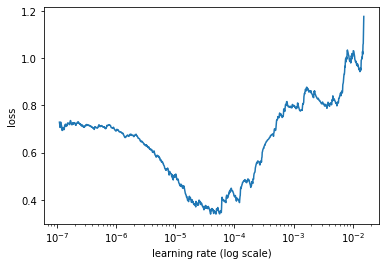

In [ ]:
learner.lr_plot()

In [ ]:
# Model wird für eine Epoche mit der Lernrate 2e-5 trainiert 
learner.fit_onecycle(2e-5, 1)



begin training using onecycle policy with max lr of 2e-05...
Train on 20000 samples, validate on 5000 samples
20000/20000 [==============================] - 3699s 185ms/sample - loss: 0.2543 - accuracy: 0.8951 - val_loss: 0.1662 - val_accuracy: 0.9352


In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc)

In [ ]:
data = [ 'This movie was horrible! The plot was boring. Acting was okay, though.',
         'The film really sucked. I want my money back.',
        'The plot had too many holes.',
        'What a beautiful romantic comedy. 10/10 would see again!', 
        'This movie is shit!']

In [ ]:
predictor.predict(data)

['negative', 'negative', 'negative', 'positive', 'negative']

In [ ]:
predictor.save('/content/gdrive/My Drive/imbd_ktrain_bert_model')

In [ ]:
predictor = ktrain.load_predictor('/content/gdrive/My Drive/imbd_ktrain_bert_model')


## 3 Ergebnis <a class="anchor" id="ergebnis"></a>

|Model | Train_acc | Train_loss | Test_acc | Test_loss|
| --- | --- | --- | --- | --- |
|GloVe NN | 0,82	| 0,37	| 0,75	| 0,74|
|GloVe CNN | 0,95 | 0,13	| 0,84	| 0,37|
|GloVe LSTM	| 0,87	| 0,30	| 0,86	| 0,33|	
|BERT-Tok CNN|__0,99__|__0,01__|0,90|0,43|	
|BERT-Model|0,94|0,14|0,91|0,23	|
|ktrain BERT|0,98|0,25|__0,93__|__0,16__|	


Zusammenfassend kann gesagt werden, dass das Verwenden des Language BERT-Models, das beste Ergebnisse der Sentiment Analyse erzielt hat. Wie in der Tabelle zu sehen ist, erreicht man durch BERT eine Prozentzahl über 90% und ein Loss-Wert von 0,16. 
Zudem wurde gezeigt, dass mithilfe von ktrain nicht nur auf effiziente und schnelle Art und Weise ein Neuronales Netzwerk trainiert und evaluiert werden kann, sondern auch, dass es unter Einbezug des BERT-Models eine Accuracy von fast 94% erreicht.